In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# !wget https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
# !unzip gsn-2021-1.zip &> /dev/null
# !rm gsn-2021-1.zip

In [3]:
class FiguresDataset(Dataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, train, transform=None):
        self.figures_frame = pd.read_csv(csv_file)
        if train:
            self.figures_frame = self.figures_frame[:9000]
        else:
            self.figures_frame = self.figures_frame[-1000:]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.figures_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.figures_frame.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True);
        figures = self.figures_frame.iloc[idx, 1:]
        figures = np.array(figures)
        figures = figures.astype('int')
        sample = (image, figures)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    def __call__(self, sample):
        image, figures = sample
        
        return (torch.from_numpy(image).float(), torch.from_numpy(figures))
    
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, figures = sample
        
        norm = transforms.Normalize(self.mean, self.std)
        image = norm(image.unsqueeze_(2)).squeeze_(2)
        
        return (image, figures)

class HorizontalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.hflip(image)
        figures[3], figures[5] = figures[5].clone(), figures[3].clone()
        
        return (image, figures)

class VerticalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.vflip(image)
        figures[2], figures[4] = figures[4].clone(), figures[2].clone() 
        
        return (image, figures)
    
class Rotate(object):
    def __init__(self):
        self.ks = [1, 2, 3]
        
    def __call__(self, sample):
        image, figures = sample
        
        k = int(np.random.choice(self.ks))        
        image = torch.rot90(image, k)
        figures[2:] = torch.roll(figures[2:], -k)
        
        return (image, figures)

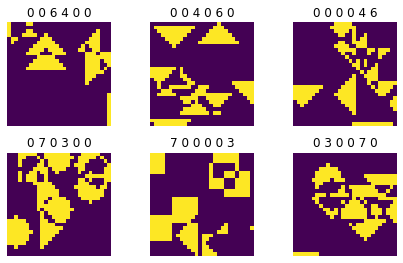

In [5]:
from random import randint

csv_file = 'data/labels.csv'
root_dir = 'data/'
figures_dataset = FiguresDataset(csv_file, root_dir, train=True)

fig = plt.figure()

for i in range(6):
    r = randint(0, len(figures_dataset))
    image, figures = figures_dataset[r]

    
    ax = plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    ax.set_title(' '.join(map(str, figures)))
    ax.axis('off')
    
    plt.imshow(image)

plt.subplots_adjust()
plt.show()

In [6]:
torch.manual_seed(1)
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if device == 'cuda':
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    


transform = transforms.Compose([ToTensor(), Normalize(mean=0.5, std=0.5)])

train_dataset = FiguresDataset(csv_file, root_dir, True, transforms.Compose([transform, transforms.RandomApply([transforms.RandomChoice([Rotate(), VerticalFlip(), HorizontalFlip()])], p=0.7)]))
test_dataset = FiguresDataset(csv_file, root_dir, False, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [7]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=.00001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.stop = False
        
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.min_delta:
            self.best_loss = loss
        elif self.best_loss - loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
    

In [8]:
def square_counting_errors(output, target):
    return torch.sum(torch.mul(output, torch.square(torch.stack([j - target for j in range(10)], dim=2))))

def eval_metric(output, target):
    pred = output.argmax(dim=2)
    return torch.sum(torch.all(torch.eq(pred, target), dim=1))
    

def train(model, device, train_loader, optimizer, log=False):
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = square_counting_errors(output, target)
        train_loss += loss.item()
        correct += eval_metric(output, target).item()
        loss.backward()
        optimizer.step()
        
        if log and batch_idx % 10 == 0:
            print('Train Batch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += square_counting_errors(output, target).item()  # sum up batch loss
            correct += eval_metric(output, target).item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

def prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    l1, = ax1.plot(train_loss, color='b', label="Train")
    l2, = ax1.plot(test_loss, color='r', label='Test')
    ax1.set_title('Losses')
    ax2.plot(train_accuracy, color='b', label="Train")
    ax2.plot(test_accuracy, color='r', label='Test')
    ax2.set_title('Accuracies')
    plt.legend([l1, l2], ["Train", "Test"])

    plt.show()

def train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping=None):
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []
    
    for epoch in range(1, epochs + 1):
        print("\nEpoch: {}/{}\n".format(epoch, epochs))
        train_loss_epoch, train_accuracy_epoch = train(model, device, train_loader, optimizer)
        test_loss_epoch, test_accuracy_epoch = test(model, device, test_loader)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_accuracy_epoch)
        test_loss.append(test_loss_epoch)
        test_accuracy.append(test_accuracy_epoch)
        
        print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(train_loss_epoch, train_accuracy_epoch))
        print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_epoch, test_accuracy_epoch))
        
        if not early_stopping == None:
            early_stopping(train_loss_epoch)
            if early_stopping.stop:
                print("Early stopped.")
                break
    
    prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy)
        


Epoch: 1/100

Train set: Average loss: 51.5547, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 50.1940, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 49.7180, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 49.9993, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 49.9007, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 50.0769, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 50.1360, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 49.7838, Accuracy: 0%
Test set: Average loss: 50.0180, Accuracy: 0%
Early stopped.


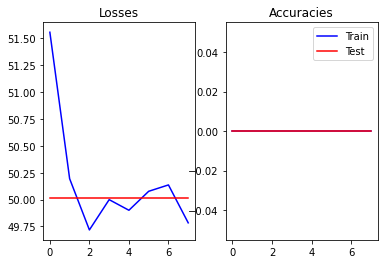

In [11]:
class Conv5Lin2(nn.Module):
    def __init__(self):
        super(Conv5Lin2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 48.9689, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 45.9676, Accuracy: 0%
Test set: Average loss: 45.1800, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 45.5768, Accuracy: 0%
Test set: Average loss: 45.1800, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 45.4339, Accuracy: 0%
Test set: Average loss: 45.1800, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 46.7598, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 46.8174, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 44.5001, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 44.6500, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 44.4592, Accuracy: 0%
Test set: Average loss: 43.7360, Accuracy: 0%

Epoch: 10/100

Train set: A

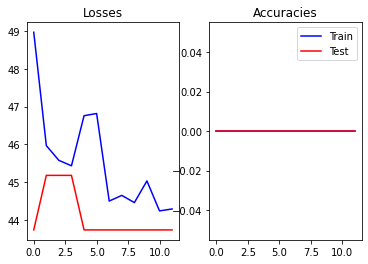

In [12]:
class Conv5Lin2DropFull(nn.Module):
    def __init__(self):
        super(Conv5Lin2DropFull, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )

    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2DropFull().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 43.8955, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 43.0382, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 42.9340, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 42.9889, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 43.0566, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 42.9699, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 42.9818, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 43.0673, Accuracy: 0%
Test set: Average loss: 42.5780, Accuracy: 0%
Early stopped.


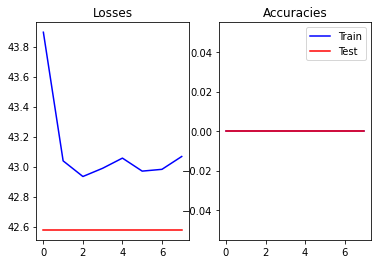

In [13]:
model = Conv5Lin2DropFull().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 40.8413, Accuracy: 0%
Test set: Average loss: 23.1441, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 15.5709, Accuracy: 0%
Test set: Average loss: 14.3250, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 12.8482, Accuracy: 1%
Test set: Average loss: 13.1495, Accuracy: 2%

Epoch: 4/100

Train set: Average loss: 11.7058, Accuracy: 4%
Test set: Average loss: 12.5348, Accuracy: 5%

Epoch: 5/100

Train set: Average loss: 10.8468, Accuracy: 5%
Test set: Average loss: 11.4738, Accuracy: 4%

Epoch: 6/100

Train set: Average loss: 10.3328, Accuracy: 4%
Test set: Average loss: 12.0841, Accuracy: 4%

Epoch: 7/100

Train set: Average loss: 10.0718, Accuracy: 4%
Test set: Average loss: 11.0601, Accuracy: 5%

Epoch: 8/100

Train set: Average loss: 9.7663, Accuracy: 4%
Test set: Average loss: 9.9108, Accuracy: 5%

Epoch: 9/100

Train set: Average loss: 9.5253, Accuracy: 4%
Test set: Average loss: 10.2128, Accuracy: 5%

Epoch: 10/100

Train set: Aver

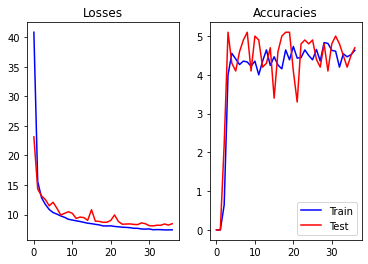

In [14]:
class Conv5Lin2BN(nn.Module):
    def __init__(self):
        super(Conv5Lin2BN, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2BN().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 43.9745, Accuracy: 0%
Test set: Average loss: 43.1331, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 42.0382, Accuracy: 0%
Test set: Average loss: 42.2661, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 42.3349, Accuracy: 0%
Test set: Average loss: 42.2784, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 42.2727, Accuracy: 0%
Test set: Average loss: 42.2794, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 42.2878, Accuracy: 0%
Test set: Average loss: 42.2796, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 42.3271, Accuracy: 0%
Test set: Average loss: 42.2796, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 42.2847, Accuracy: 0%
Test set: Average loss: 42.2796, Accuracy: 0%
Early stopped.


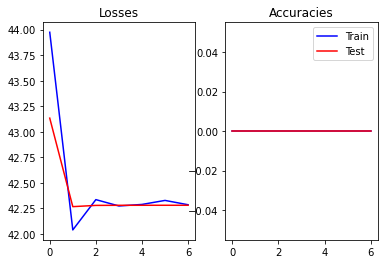

In [33]:
model = Conv5Lin2BN().to(device) # Wasn't able to get it to converge with any learning rate so I've decided to stick with Adam
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.1, nesterov=True)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 36.6740, Accuracy: 0%
Test set: Average loss: 18.5317, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 13.7562, Accuracy: 2%
Test set: Average loss: 12.5574, Accuracy: 5%

Epoch: 3/100

Train set: Average loss: 11.5876, Accuracy: 8%
Test set: Average loss: 11.8562, Accuracy: 8%

Epoch: 4/100

Train set: Average loss: 10.6361, Accuracy: 8%
Test set: Average loss: 11.0040, Accuracy: 8%

Epoch: 5/100

Train set: Average loss: 10.1075, Accuracy: 8%
Test set: Average loss: 12.1215, Accuracy: 8%

Epoch: 6/100

Train set: Average loss: 9.7242, Accuracy: 8%
Test set: Average loss: 11.2766, Accuracy: 8%

Epoch: 7/100

Train set: Average loss: 9.4337, Accuracy: 9%
Test set: Average loss: 10.2893, Accuracy: 8%

Epoch: 8/100

Train set: Average loss: 9.1378, Accuracy: 8%
Test set: Average loss: 9.8439, Accuracy: 8%

Epoch: 9/100

Train set: Average loss: 9.0107, Accuracy: 9%
Test set: Average loss: 9.8357, Accuracy: 8%

Epoch: 10/100

Train set: Average

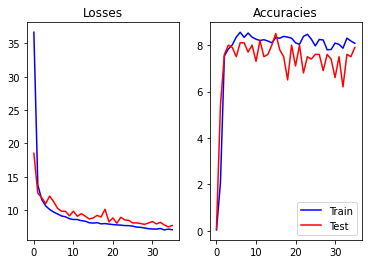

In [45]:
model = Conv5Lin2BN().to(device) # So I though I'd just try Adam with weight decay
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 38.9113, Accuracy: 0%
Test set: Average loss: 18.1709, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 14.2165, Accuracy: 1%
Test set: Average loss: 13.5909, Accuracy: 3%

Epoch: 3/100

Train set: Average loss: 11.6095, Accuracy: 5%
Test set: Average loss: 11.3349, Accuracy: 7%

Epoch: 4/100

Train set: Average loss: 10.5496, Accuracy: 6%
Test set: Average loss: 12.2670, Accuracy: 6%

Epoch: 5/100

Train set: Average loss: 9.9773, Accuracy: 5%
Test set: Average loss: 13.6615, Accuracy: 5%

Epoch: 6/100

Train set: Average loss: 9.5060, Accuracy: 5%
Test set: Average loss: 9.3182, Accuracy: 6%

Epoch: 7/100

Train set: Average loss: 9.1179, Accuracy: 5%
Test set: Average loss: 10.6040, Accuracy: 6%

Epoch: 8/100

Train set: Average loss: 8.7970, Accuracy: 5%
Test set: Average loss: 9.8485, Accuracy: 6%

Epoch: 9/100

Train set: Average loss: 8.6034, Accuracy: 6%
Test set: Average loss: 9.6372, Accuracy: 6%

Epoch: 10/100

Train set: Average l

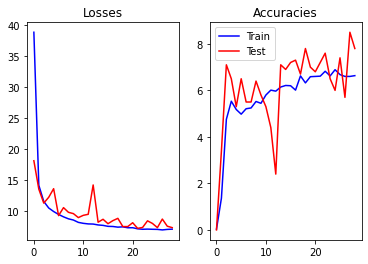

In [47]:
class Conv6Lin2BN(nn.Module):
    def __init__(self):
        super(Conv6Lin2BN, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 16 * 16, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv6Lin2BN().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 36.2436, Accuracy: 0%
Test set: Average loss: 14.6575, Accuracy: 1%

Epoch: 2/100

Train set: Average loss: 11.9477, Accuracy: 4%
Test set: Average loss: 17.1376, Accuracy: 4%

Epoch: 3/100

Train set: Average loss: 9.9011, Accuracy: 6%
Test set: Average loss: 10.7182, Accuracy: 8%

Epoch: 4/100

Train set: Average loss: 9.0994, Accuracy: 7%
Test set: Average loss: 10.2900, Accuracy: 8%

Epoch: 5/100

Train set: Average loss: 8.6114, Accuracy: 7%
Test set: Average loss: 10.1360, Accuracy: 6%

Epoch: 6/100

Train set: Average loss: 8.3049, Accuracy: 7%
Test set: Average loss: 9.4407, Accuracy: 8%

Epoch: 7/100

Train set: Average loss: 8.0230, Accuracy: 7%
Test set: Average loss: 9.8544, Accuracy: 5%

Epoch: 8/100

Train set: Average loss: 7.7260, Accuracy: 7%
Test set: Average loss: 9.5413, Accuracy: 7%

Epoch: 9/100

Train set: Average loss: 7.6697, Accuracy: 7%
Test set: Average loss: 16.8979, Accuracy: 4%

Epoch: 10/100

Train set: Average los

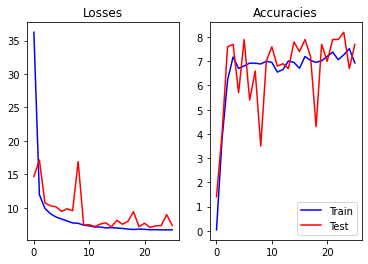

In [48]:
class Conv5Lin2BNPad(nn.Module):
    def __init__(self):
        super(Conv5Lin2BNPad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2BNPad().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 40.5336, Accuracy: 0%
Test set: Average loss: 19.3093, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 14.6635, Accuracy: 0%
Test set: Average loss: 15.8840, Accuracy: 1%

Epoch: 3/100

Train set: Average loss: 12.1210, Accuracy: 4%
Test set: Average loss: 12.4554, Accuracy: 3%

Epoch: 4/100

Train set: Average loss: 11.1473, Accuracy: 5%
Test set: Average loss: 13.8348, Accuracy: 3%

Epoch: 5/100

Train set: Average loss: 10.4886, Accuracy: 5%
Test set: Average loss: 12.1883, Accuracy: 4%

Epoch: 6/100

Train set: Average loss: 10.0674, Accuracy: 5%
Test set: Average loss: 10.5161, Accuracy: 4%

Epoch: 7/100

Train set: Average loss: 9.7502, Accuracy: 6%
Test set: Average loss: 12.2977, Accuracy: 3%

Epoch: 8/100

Train set: Average loss: 9.5120, Accuracy: 5%
Test set: Average loss: 12.2863, Accuracy: 2%

Epoch: 9/100

Train set: Average loss: 9.1451, Accuracy: 5%
Test set: Average loss: 9.4389, Accuracy: 4%

Epoch: 10/100

Train set: Avera

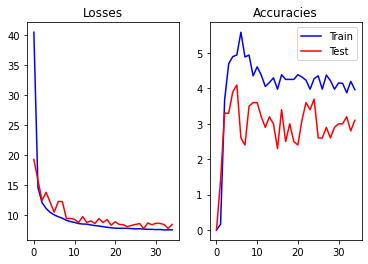

In [51]:
class Conv5Lin2BNPool3(nn.Module):
    def __init__(self):
        super(Conv5Lin2BNPool3, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2BNPool3().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 49.2049, Accuracy: 0%
Test set: Average loss: 23.3585, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 20.9034, Accuracy: 0%
Test set: Average loss: 18.7175, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 18.0879, Accuracy: 0%
Test set: Average loss: 16.4853, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 16.8928, Accuracy: 0%
Test set: Average loss: 15.9376, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 16.1536, Accuracy: 0%
Test set: Average loss: 15.2444, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 15.7814, Accuracy: 0%
Test set: Average loss: 14.7189, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 15.3639, Accuracy: 0%
Test set: Average loss: 14.4881, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 15.1699, Accuracy: 0%
Test set: Average loss: 14.7628, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 14.9056, Accuracy: 0%
Test set: Average loss: 14.4723, Accuracy: 0%

Epoch: 10/100

Train set: A

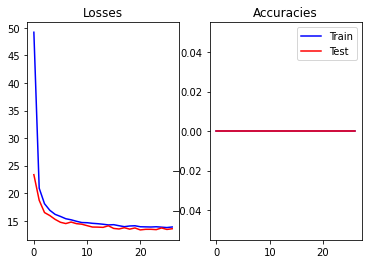

In [53]:
class Conv5Lin2BNDropFull(nn.Module):
    def __init__(self):
        super(Conv5Lin2BNDropFull, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2BNDropFull().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 80.2772, Accuracy: 0%
Test set: Average loss: 60.7796, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 52.3273, Accuracy: 0%
Test set: Average loss: 46.9930, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 40.5586, Accuracy: 0%
Test set: Average loss: 38.6084, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 33.2359, Accuracy: 0%
Test set: Average loss: 30.9033, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 28.2280, Accuracy: 0%
Test set: Average loss: 27.2442, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 24.0049, Accuracy: 0%
Test set: Average loss: 22.9371, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 20.8176, Accuracy: 0%
Test set: Average loss: 21.7017, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 18.2838, Accuracy: 0%
Test set: Average loss: 18.3940, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 16.2953, Accuracy: 0%
Test set: Average loss: 16.1053, Accuracy: 0%

Epoch: 10/100

Train set: A

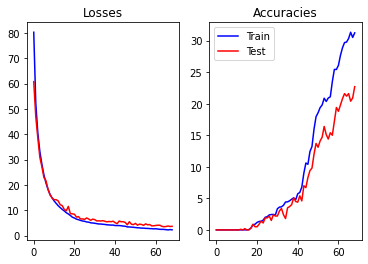

In [14]:
class Conv5Lin2BNFull(nn.Module):
    def __init__(self):
        super(Conv5Lin2BNFull, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.BatchNorm1d(60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2BNFull().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 71.3813, Accuracy: 0%
Test set: Average loss: 54.9011, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 46.7061, Accuracy: 0%
Test set: Average loss: 47.0535, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 36.3470, Accuracy: 1%
Test set: Average loss: 32.5708, Accuracy: 1%

Epoch: 4/100

Train set: Average loss: 29.8026, Accuracy: 1%
Test set: Average loss: 30.3929, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 25.3702, Accuracy: 1%
Test set: Average loss: 23.4890, Accuracy: 1%

Epoch: 6/100

Train set: Average loss: 21.6404, Accuracy: 1%
Test set: Average loss: 19.4448, Accuracy: 1%

Epoch: 7/100

Train set: Average loss: 18.4138, Accuracy: 1%
Test set: Average loss: 17.0712, Accuracy: 1%

Epoch: 8/100

Train set: Average loss: 16.0341, Accuracy: 1%
Test set: Average loss: 18.1582, Accuracy: 1%

Epoch: 9/100

Train set: Average loss: 14.3892, Accuracy: 1%
Test set: Average loss: 15.3140, Accuracy: 1%

Epoch: 10/100

Train set: A

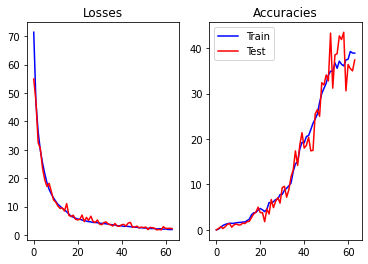

In [13]:
class Conv7Lin3BNFullPad(nn.Module):
    def __init__(self):
        super(Conv7Lin3BNFullPad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(512 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 60),
            nn.BatchNorm1d(60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv7Lin3BNFullPad().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 72.6883, Accuracy: 0%
Test set: Average loss: 56.8987, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 46.4822, Accuracy: 0%
Test set: Average loss: 43.0231, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 36.3637, Accuracy: 0%
Test set: Average loss: 31.6514, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 29.8325, Accuracy: 0%
Test set: Average loss: 32.4203, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 25.2518, Accuracy: 0%
Test set: Average loss: 31.7053, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 21.2513, Accuracy: 0%
Test set: Average loss: 19.6385, Accuracy: 1%

Epoch: 7/100

Train set: Average loss: 17.8616, Accuracy: 1%
Test set: Average loss: 18.0050, Accuracy: 1%

Epoch: 8/100

Train set: Average loss: 15.5359, Accuracy: 1%
Test set: Average loss: 16.0353, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 13.7912, Accuracy: 1%
Test set: Average loss: 13.5982, Accuracy: 1%

Epoch: 10/100

Train set: A

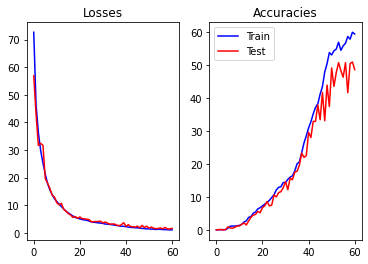

In [14]:
model = Conv7Lin3BNFullPad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 72.8740, Accuracy: 0%
Test set: Average loss: 56.7415, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 46.8479, Accuracy: 0%
Test set: Average loss: 41.6063, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 36.3959, Accuracy: 0%
Test set: Average loss: 34.8414, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 29.8400, Accuracy: 0%
Test set: Average loss: 30.0427, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 24.9048, Accuracy: 0%
Test set: Average loss: 23.3214, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 20.8776, Accuracy: 0%
Test set: Average loss: 23.6134, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 17.7770, Accuracy: 0%
Test set: Average loss: 19.0736, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 15.3599, Accuracy: 0%
Test set: Average loss: 15.1974, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 13.7653, Accuracy: 0%
Test set: Average loss: 13.5774, Accuracy: 0%

Epoch: 10/100

Train set: A

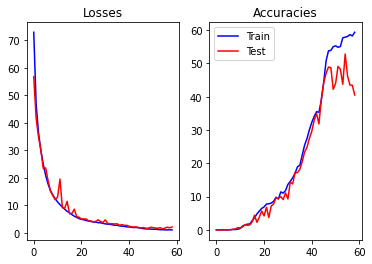

In [15]:
class Conv8Lin3BNFullPad(nn.Module):
    def __init__(self):
        super(Conv7Lin3BNFullPad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 60),
            nn.BatchNorm1d(60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv7Lin3BNFullPad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 102.8875, Accuracy: 0%
Test set: Average loss: 72.1330, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 61.4079, Accuracy: 0%
Test set: Average loss: 50.3792, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 47.2505, Accuracy: 0%
Test set: Average loss: 40.1837, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 38.7426, Accuracy: 0%
Test set: Average loss: 32.5261, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 32.9859, Accuracy: 0%
Test set: Average loss: 27.8397, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 28.7774, Accuracy: 0%
Test set: Average loss: 24.5615, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 25.3417, Accuracy: 0%
Test set: Average loss: 20.7827, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 22.2794, Accuracy: 0%
Test set: Average loss: 17.6655, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 20.0006, Accuracy: 0%
Test set: Average loss: 15.7990, Accuracy: 0%

Epoch: 10/100

Train set: 

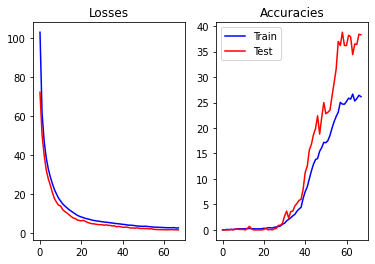

In [9]:
class Conv8Lin3BNFullDropFullPad(nn.Module):
    def __init__(self):
        super(Conv8Lin3BNFullDropFullPad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 60),
            nn.BatchNorm1d(60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv8Lin3BNFullDropFullPad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 71.1264, Accuracy: 0%
Test set: Average loss: 57.1324, Accuracy: 0%

Epoch: 2/100

Train set: Average loss: 46.4414, Accuracy: 0%
Test set: Average loss: 41.4625, Accuracy: 0%

Epoch: 3/100

Train set: Average loss: 36.0542, Accuracy: 0%
Test set: Average loss: 35.9407, Accuracy: 0%

Epoch: 4/100

Train set: Average loss: 29.6046, Accuracy: 0%
Test set: Average loss: 28.1155, Accuracy: 0%

Epoch: 5/100

Train set: Average loss: 24.8923, Accuracy: 0%
Test set: Average loss: 24.4584, Accuracy: 0%

Epoch: 6/100

Train set: Average loss: 20.8760, Accuracy: 0%
Test set: Average loss: 19.2731, Accuracy: 0%

Epoch: 7/100

Train set: Average loss: 17.5826, Accuracy: 0%
Test set: Average loss: 15.6264, Accuracy: 0%

Epoch: 8/100

Train set: Average loss: 15.3589, Accuracy: 0%
Test set: Average loss: 14.9917, Accuracy: 0%

Epoch: 9/100

Train set: Average loss: 13.6726, Accuracy: 0%
Test set: Average loss: 12.7162, Accuracy: 0%

Epoch: 10/100

Train set: A

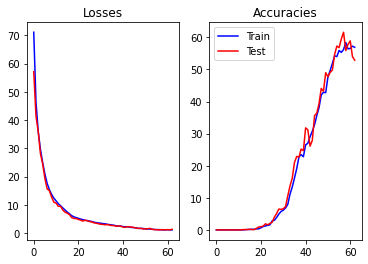

In [10]:
class Conv8Lin3BNFullPool3Pad(nn.Module):
    def __init__(self):
        super(Conv8Lin3BNFullPool3Pad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 60),
            nn.BatchNorm1d(60),
            nn.Unflatten(1, (6, 10)),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv8Lin3BNFullPool3Pad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)